# 1. Titanic (Regression)

https://www.kaggle.com/c/titanic/overview

출력을 csv파일로 저장하여 함께 제출

submit predictions에 테스트해 볼 것!

어떠한 알고리즘을 사용하여도 무방함

참조: https://www.kaggle.com/alexisbcook/getting-started-with-titanic

In [27]:
import numpy as np 
import pandas as pd
import torch
from sklearn.preprocessing import minmax_scale

In [28]:
train_df = pd.read_csv('./titanic/train.csv')
test_df = pd.read_csv('./titanic/test.csv')

In [29]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [30]:
# 훈련 자료 int, float 변수 통계치
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [31]:
#불필요하다고 생각된 기존 데이터에서 지우기 식별번호, 이름, 티켓 구별 번호,티켓요금, 탑승항구를 기존 배열에서 제거
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket',"Fare","Embarked"], axis=1)
test_df = test_df.drop(['Name','Ticket',"Fare","Embarked"], axis=1)

#정보에 nan이 너무 많아 정확한 분석이 불가능해서 제외
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [32]:
#Pclass 데이터는 1등급 2등급 3등급을 나타내며 
#수치적으로 아무 의미 없는 데이터이므로 경우의 수로 판단해 3개의 경우로 나눈다


#Pclass를 3개의 경우로 나누기
pclass_train_dummies = pd.get_dummies(train_df['Pclass'])#학습
pclass_test_dummies = pd.get_dummies(test_df['Pclass'])#테스트

#변경전 내용 기존 데이터에서 제거
train_df.drop(['Pclass'], axis=1, inplace=True)
test_df.drop(['Pclass'], axis=1, inplace=True)

#변경된 내용 기존 데이터에 추가
train_df = train_df.join(pclass_train_dummies)
test_df = test_df.join(pclass_test_dummies)


In [33]:
#성별을 계산하기 위해 성별을 경우로 분리

#성별을 2개의 경우로 나누기
sex_train_dummies = pd.get_dummies(train_df['Sex'])
sex_test_dummies = pd.get_dummies(test_df['Sex'])

#나눈 경우를 구별하기 위해 분류에 이름 붙이기
sex_train_dummies.columns = ['Female', 'Male']
sex_test_dummies.columns = ['Female', 'Male']

#변경전  성별테이터 제거
train_df.drop(['Sex'], axis=1, inplace=True)
test_df.drop(['Sex'], axis=1, inplace=True)

#변경 된 데이터 추가
train_df = train_df.join(sex_train_dummies)
test_df = test_df.join(sex_test_dummies)

In [34]:
#나이값이 없는 경우가 있는데 nan데이터가 들어가면 함수가 고장나므로
#나이의 평균값을 집어 넣기로 함

#나이 nan값에 평균값 집어넣기
train_df["Age"].fillna(train_df["Age"].mean() , inplace=True)
test_df["Age"].fillna(train_df["Age"].mean() , inplace=True)

In [35]:
#편의를 위한 데이터 분리

#기존 데이터에서 정답 드랍
X_train = train_df.drop("Survived",axis=1)
#정답 데이터 제작 
Y_train = train_df["Survived"]
#정답 확인을 위해 ID가 필요는 하지만 인풋으로 넣을 필요는 없어 인풋에서만 제거한 데이터 파일 제작
X_test  = test_df.drop("PassengerId",axis=1).copy()


Y_train=np.array(Y_train,ndmin=2)#형식 맞추기1. 차원 수 맞추기
Y_train=Y_train.T#형식 맞춰주기2. 배열 형태 맞추기


In [36]:

#정규화 데이터 :중요도를 몰라 수치적 크기가 의미가 없다고 판단
X_train=minmax_scale(X_train)
Y_train=minmax_scale(Y_train)
X_test=minmax_scale(X_test)

In [37]:
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)
X_test = torch.Tensor(X_test)
#torch에서 지원하는 형식으로 맞춰주기

In [38]:
print(X_train.shape)
print(Y_train.shape)
#데이터 크기 확인 인풋 크기 정할때 사용

torch.Size([891, 8])
torch.Size([891, 1])


In [39]:
din, dh, dout = 8,24,1#입력 히든 아웃
model = torch.nn.Sequential(
    torch.nn.Linear(din,dh),  # 인풋-히든
    torch.nn.Sigmoid(),       #레이어에서 사용할 함수 Sigmoid
    torch.nn.Linear(dh,dout), # 히든-아웃
    torch.nn.Sigmoid()        #레이어에서 사용할 함수 Sigmoid
)

In [40]:
print(model(X_train).shape)#데이터 양식 확인

torch.Size([891, 1])


In [41]:
learning_rate = 1e-3 #학습강도
criterion = torch.nn.MSELoss()#손실 함수 MSELoss 사용
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)#Optimizer 로 Adam 사용
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [42]:
nb_epochs = 4500# 학습 횟수
for t in range(nb_epochs+1):
    y_pred = model(X_train)#모델이 예측한 값을 저장
    loss = criterion(y_pred,Y_train)#오차평균 저장
    optimizer.zero_grad() #미분값 초기화 안하면 값 누적
    loss.backward() # 역전파
    optimizer.step() # update weights and biases
    if t % 1000 == 0:#그냥 출력문 1000번마다 출력
        prediction = model(X_train) >= torch.FloatTensor([0.5])#답결정 0.5보다 크면 참 작으면 거짓
        corrects = (prediction == Y_train)#데이터 부울 값으로 저장
        accuracy = corrects.sum().float() / float( Y_train.size(0) )#정확도 게산
        print( "t=", t, "accu=", accuracy.item())#t 시행횟수 accu 정확도


t= 0 accu= 0.6161616444587708
t= 1000 accu= 0.8092031478881836
t= 2000 accu= 0.8125701546669006
t= 3000 accu= 0.8181818127632141
t= 4000 accu= 0.8193041682243347


In [43]:
#csv에 넣을 배열 만들기
#양식에 맞게 데이터를 구성 부울 값이 1과0으로 인식할 줄 알았으나 참과 거짓으로 인식해서 부울 값 기반으로 숫자 배열을 다시생성
prediction = model(X_test) >= torch.FloatTensor([0.5])#답결정
fff = [0 for i in range(418)]
for i in range(418):
    if( prediction[i]):#값이 참이면
        fff[i]=1#생존
    else:
        fff[i]=0#사망
       

In [44]:
print(prediction.shape)#데이터 크기 확인

torch.Size([418, 1])


In [45]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": fff
    })
submission.to_csv('titanic.csv', index=False)
#csv파일변환

오버피팅이 언제나는지 알기가 어려워서 여러번 실험해봤다

3000번~4500번 사이에서 학습을 하면 이후로 결과가 어느정도 수렴해 정확도가
78% 근처로 나온다

노드수는 바꿔 보았지만 정확도에 큰 영향을 주지는 못했다. 
노드수를 늘리는 것보다도 오버피팅을 잡는게 정확도 향상에 도움이 되었다.

최대정확도는 0.78947이였고 오버피팅 직전에 운좋게 걸린 값 같다.

가격과 승선항을 제거해도 정확도에 큰 하강폭이 없는 것으로 볼 때 큰 의미가 있는 요소는 아닌 것으로 보인다.

같은 모델에서도 오버피팅 유무에 따라 정확도 차이가 크게 나는데
오버피팅으로 0.67942까지 정확도가 떨어졌었다
오버피팅을 잡는게 정확도 향상에 큰 도움이 되는 것으로 보인다.

다른 모델도 만들어보았으나 기존 Adam, Sigmoid를 사용한 모델보다 정확도가 평균적으로 조금 낮거나 많이 떨어져 버렸다.

# 2. Image classification with CNN

cnn을 이용하여 다음 이미지를 분류하여라.

인풋 데이터는 rgb 정보를 가지고 있다.

코드, 결과, 보고서를 함께 제출하여야 한다.

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms

In [47]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False
)

classes = trainset.classes
classes

Files already downloaded and verified
Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

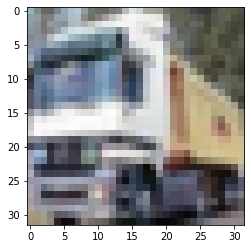

In [48]:
import matplotlib.pyplot as plt

images=train_loader.dataset[1][0]
plt.imshow(images.permute(1, 2, 0))

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")#GPU초기셋팅

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [50]:
import torch.nn as nn
import torch.nn.functional as F




class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv1 = nn.Conv2d(3, 600, 3)#RGB값이라 인 체널이 3, 필터수 , 필터에 한픽셀에 들어갈 정보 크기(Kernel Size)
        #결과 값=데이터 행 크기-(Kernel Size-1)
        #결과값*결과값*데이터 층 수*필터수
        self.pool = nn.MaxPool2d(2, 2)#결과물 크기 반(1/2)으로 줄이기
        #((결과 값)/2:나머지 버림)*((결과 값)/2)*데이터 층 수*필터수
        #self.conv2 = nn.Conv2d(600, 320, 3)
        
        self.conv1 = nn.Conv2d(3, 600, 5)
    
        self.conv2 = nn.Conv2d(600, 320, 5)
        
        self.fc1 = nn.Linear(320 * 5 * 5, 120)#인풋320*5*5  아웃120
        self.fc2 = nn.Linear(120, 84)#인풋120  아웃84
        self.fc3 = nn.Linear(84, 10)#인풋84  아웃10

    def forward(self, x):
        #입력 4*32*32 (RGP+밝기=4)
        x = self.pool(F.relu(self.conv1(x)))#F.relu와 nn.relu는 거의 같으며 호출방식의 차이다.
        #1. self.conv1(x) 처리 [32-(5-1)=28]*[28]*4*600=28*28*600*4
        #2. relu() 사용
        #3. self.pool() 처리 [28/2=14]*[14]*4*600=14*14*600*4
        
        x = self.pool(F.relu(self.conv2(x)))
        #1. self.conv1(x) 처리 [14-(5-1)=10]*[10]*4*320=10*10*320*4
        #2. relu() 사용
        #3. self.pool() 처리 [10/2]*[5]*4*600=5*5*320*4 :4는 층수
    
        
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten) 
        x = F.relu(self.fc1(x)) #fc1신경망에서 relu 사용
        x = F.relu(self.fc2(x)) #fc2신경망에서 relu 사용
        x = self.fc3(x)
        return x


net = Net()
net.to(device)#GPU셋팅

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 600, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(600, 320, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=8000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [51]:
import torch.optim as optim
learning_rate=0.001
criterion = nn.CrossEntropyLoss()#손실 함수 CrossEntropyLoss 사용
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)#최적화 SGD 사용 Ir:학습속도 momentum 관성 이동방향으로 
#optimizer = optim.RMSprop(net.parameters(),lr=0.001)

In [52]:
for epoch in range(30):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        #inputs, labels = data 일반 셋팅
        inputs, labels = data[0].to(device), data[1].to(device)#GPU 셋팅

       
        optimizer.zero_grad()#미분값 초기화 안하면 값 누적

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)# 모델 예측값 저장
        loss = criterion(outputs, labels)# 평균 오차
        loss.backward()#역전파
        optimizer.step()#최적화

        #테스트예상 오차비교 출력합니다.
     
        if i % 2000 == 1999:    # 거의 2000번째마다 작동
   
            correct = 0
            total = 0
          
            with torch.no_grad(): # no update
                for data in test_loader:
                    images, labels = data[0].to(device), data[1].to(device)#GPU셋팅
                    outputs = net(images)#테스트 모델로 예측값 뽑기
                   
                    _, predicted = torch.max(outputs.data, 1)#예측값중 가장 높은 값을 답으로 선택
                    total += labels.size(0)#전체 데이터 수
                    correct += (predicted == labels).sum().item()#정확도 계산
                    

            print(epoch + 1, i + 1,"accu=", correct / total)#정확도  출력

print('Finished Training')


1 2000 accu= 0.1612
1 4000 accu= 0.2555
1 6000 accu= 0.3113
1 8000 accu= 0.3641
1 10000 accu= 0.4055
1 12000 accu= 0.4268
2 2000 accu= 0.4372
2 4000 accu= 0.4597
2 6000 accu= 0.4716
2 8000 accu= 0.4971
2 10000 accu= 0.4852
2 12000 accu= 0.502
3 2000 accu= 0.5192
3 4000 accu= 0.5341
3 6000 accu= 0.5342
3 8000 accu= 0.5559
3 10000 accu= 0.5511
3 12000 accu= 0.5811
4 2000 accu= 0.5992
4 4000 accu= 0.6074
4 6000 accu= 0.5911
4 8000 accu= 0.6143
4 10000 accu= 0.6167
4 12000 accu= 0.6047
5 2000 accu= 0.6052
5 4000 accu= 0.6323
5 6000 accu= 0.6381
5 8000 accu= 0.6431
5 10000 accu= 0.6438
5 12000 accu= 0.6554
6 2000 accu= 0.6688
6 4000 accu= 0.6614
6 6000 accu= 0.6673
6 8000 accu= 0.6436
6 10000 accu= 0.6719
6 12000 accu= 0.6661
7 2000 accu= 0.6777
7 4000 accu= 0.6494
7 6000 accu= 0.684
7 8000 accu= 0.6804
7 10000 accu= 0.6477
7 12000 accu= 0.677
8 2000 accu= 0.6864
8 4000 accu= 0.6885
8 6000 accu= 0.6814
8 8000 accu= 0.6974
8 10000 accu= 0.6939
8 12000 accu= 0.6949
9 2000 accu= 0.7022
9 4000 

In [53]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():# no update
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane is: 80.3 %
Accuracy for class automobile is: 84.4 %
Accuracy for class bird  is: 62.5 %
Accuracy for class cat   is: 58.2 %
Accuracy for class deer  is: 70.4 %
Accuracy for class dog   is: 64.0 %
Accuracy for class frog  is: 81.4 %
Accuracy for class horse is: 78.6 %
Accuracy for class ship  is: 85.3 %
Accuracy for class truck is: 83.1 %


처음에는 일반 CPU계산으로 돌렸으나 GPU계산이 가능하다는 걸 알고 GPU계산을 이용했는데
엄청난 속도차이를 보인다. Conv2d 채널 수를 600개로 실행할 때
CPU와 비교해서 압도적으로 빠르게 작동 했다.

여러 모델을 사용해봤으나 해당 모델에서 노드와 채널(필터)수만 늘리는게 가장 정확도가 높았다.

채널 수는 그대로 두고 신경망 노드 수만 올리면 정확도가 크게 오르지는 않았다.


오버피팅이 나기 전까지 동조건에서 채널수와 노드수를 변경하며 최고 정확도를 비교해봤다

    (채널수,초기 노드 수)

    (6,16)는 59% 최대치 이후 오버 피팅이 났다 (20번 학습)

    (60,32)는 68% 최대치 이후 오버 피팅이 났다 (20번 학습)

    (600,320)은 73%정도 이후로 오버피팅이 났다 (20번 학습).

    (600,320,1200<-히든 노드 수 추가 증가) 74% 이후 오버피팅 (10번 학습) 히든 노드 수를 대량으로 늘리는 건 큰 효과가 없었다
    
    이 이상으로는 연산속도가 너무 느려서 이 컴퓨터로는 한계인 것 같다

채널수와 노드수가 증가할수록 유사한 모델에서 최대 정확도가 증가하는 현상을 보였다.
레이어 층수는 어느정도 증가시켜 보았지만 연산 속도가 심하게 느려지는 것 외에는 큰 이득이 없었고
최대 정확도는 크게 변하지 않았다.

최적화

        Adam을 사용해 봤으나 20회 동조건 학습(600,320)에서 67%로 학습속도도 느리고 SGD(73%)보다 정확도가 떨어졌다.
        RMSprop을 동조건에서 사용해보았으나 66%가 최대치였다.
        SGD사용시 momentum를 0.95로하면 정확도가 떨어진다. 0.8로 두면 0.9와 비슷하고 
        0.5로 두면 학습 속도가 떨어졌지만 정확도는 75%이후로 오버피팅이 났다. 30회 정도에서 75% 근처에 도달한다.
        정확도가 비교적 정확도가 1~2%정도 높게 나오고 최대 75%까지 올랐는데 단순한 학습속도 원인은 아닌 것으로 보인다.
        학습속도를 낮춰 실험해 봤으나 불안정하게 73%까지 도달하기만 하고 75%에 도달하진 못했다. 
        


참고한 코드에서 Kernel Size를 5로 뒀었는데 일반적으로 3으로 두던데 왜 5로 뒀는지 계산해보니

    x = self.pool(F.relu(self.conv2(x)))부분에서 Kernel Size를 3으로두면 self.pool에서 1픽셀 손실이 발생한다.

    self.pool() 처리에서 (13/2)x(13/2)x4x600=>6x6x320x4

    처리과정에서 13/2가 6으로 내려간다.
    실제계산에서는 5로 두던 3으로 두던 큰 차이는 없었다. 
    Kernel Size를 3으로 두면 정보량 증가로 정확도 상승이 있을 것이라 생각했는데
    1픽셀 정보 손실이 발생했으나 결과적으로 동조건에서 정확도 최대치 변화가 없었다.
    사진 모서리 부분 정보 손실이라 유의미한 데이터를 포함하지 않았던 모양이다.


결과적으로 신경망 인풋 정보량이 증가하면 정확도가 상승하는 경향을 보였다.

이미지 별로 정확도 예측에서
각각의 정확도 예측이 비슷할 줄 알았으나 45%에서~82%정도 차이를 보이는 경우도 있었다.
특히나 고양이 대부분의 모델에서 정확도가 매우 낮았다
10장 정도의 사진 데이터를 보고 내린 추측이지만

정확도가 높은 데이터들의 공통점

    1.전체 모습이 보이는 데이터가 많다.
    2.색은 달라도 2차원적 형태가 비슷하다. 

    ex)개구리는 거의 대부분 위에서 찍었고 전체모습이 보인다.
    ex)말은 색이 달라도 형태가 비슷한 말이 많았고 대부분 측면을 많이 찍었다.
 
정확도가 낮은 데이터들의 공통점

    1.전체 모습이 잘 안보인다. 
    2.색은 같아도 2차원적 형체가 다르다.

    ex)고양이 머리만 찍었거나 뭔가에 가려져 있는 데이터도 있었고 무었보다 데이터를 사방에서 찍었다.
    ex)새 타조 참새 닭 등등 형체가 다른게 같은 분류로 구성되어있었고 찍은 구도도 달랐고 타조 머리만 찍힌 것도 있었다.

이를 토대로 이 모델에서 예상되는 해결해야 할 문제는 다음과 같다
    

    1.이미지를 2차원으로 인식하는 문제 고양이 정면과 측면, 후면을 구별 못하는 것 같다. 
        대상을 입체적으로 판단할 수 있어야한다. 
        ->이 문제는 대상을 다방면에서 학습시키면 어느정도 해결될 것으로 보인다.
        ->완전한 해결을 위해서는 관측 방향을 경우의 수로 나누어 분리해야하는데 그게 어느정도는 가능해보이지만
        모든 경우를 나누는 건 불가능해보인다. 
        
    
    2.고양이의 관절 움직임 즉 고양이가 다른 자세를 하면 못 알아보는 것 같다.
        대상의 관절 동작 가능 범위를 알아야한다.
        ->이건 유연한 생물일수록 경우의 수가 증가하는데 3번 문제가 해결되면 해결 가능해보인다
    
    3.부분적으로 인식을 못하는 문제 고양이 전체와 고양이 머리를 구별 못하는 것 같다.
        이미지를 부분적으로 비교할 수 있어야한다.
        ->이 문제는 대상을 부분적으로 분리해서 인식해야하는데 이 부분은 데이터 자체를 분할해서 학습시킨뒤
        여러 모델을 종류별로 돌려서 이미지에서 일치하는 요소를 확인해야한다.
        이 과정은 단순한 과정으로 처리 할 수 없을 것 같다. 단순히 봐도 3차원 회전 문제가 있기 때문에 단순하게 계산하면 요구 연산량이 엄청날 것으로 보인다.
        단순한 해법으로는 가능한 경우의 수 전체를 데이터로 입력해 분류 학습하면 가능하지만 그렇게 되면 아주 방대한 양의 데이터가 필요할 것으로 보인다.
        
결과적으로 새로운 데이터 분석 기술이 나오지 않는한 막대한 양의 데이터 학습 외에는 이 학습 모델에 대한 문제 해결책은 마땅히 없는 것 같다.
